In [1]:
import numpy as np
from proj1_helpers import *
from tools import *
from implementations import *
from costs import *
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
seed = 10

## Auxiliary Functions

In [2]:
# Generate Test parameters

def gen_para(lambdas, degrees):
    test_para = []
    for la in lambdas:
        for d in range(8, degrees + 1):
            test_para.append((la,d))
    return test_para

In [3]:
# Cross validation

def cross_validation(y, x, k_indices, k, lambda_):
    test_indice = k_indices[k]
    train_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    train_indice = train_indice.reshape(-1)

    ty_test = y[test_indice]
    ty_train = y[train_indice]
    tx_test = x[test_indice]
    tx_train = x[train_indice]
    
    weight, loss_train = ridge_regression(ty_train, tx_train, lambda_)

    y_train_pred = predict_labels(weight, tx_train)
    y_test_pred = predict_labels(weight, tx_test)

    accuracy_train = compute_accuracy(y_train_pred, ty_train)
    accuracy_test = compute_accuracy(y_test_pred, ty_test)
    loss_test = compute_loss(ty_test, tx_test, weight)

    return accuracy_train, accuracy_test, loss_train, loss_test

In [4]:
def  plot_accurecy_chart(degrees, train_acc, test_acc, total_acc, lambda_, jet_no):

    plt.plot(degrees, train_acc, color='b', marker='*', label="Train Accuray" )
    plt.plot(degrees, test_acc, color='r', marker='*', label="Test Accuracy" )
    plt.plot(degrees, total_acc, color='g', marker='*', label="Average Accuray" )
    plt.xlabel("Degrees")
    plt.ylabel("Accuracy")
    plt.title("Ridge regression accuracy lambda = {} jet_no = {}".format(lambda_, jet_no))  
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [5]:
def plot_loss_chart(degrees, train_loss, test_loss, total_loss, lambda_, jet_no):
    
    plt.plot(degrees, train_loss, color='b', marker='*', label="Train Loss" )
    plt.plot(degrees, test_loss, color='r', marker='*', label="Test Loss" )
    plt.xlabel("Degrees")
    plt.ylabel("Loss")
    plt.title("Ridge regression loss, lambda = {}, jet_no = {}".format(lambda_, jet_no))
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [6]:
# Display the best parameters 
def find_max(result):
    jet_no = list(set([x["idx"] for x in result]))
    for no in jet_no:
        jet_dict = {x["acc"][2]: x["param"] for x in result if x["idx"] == no}

        order = sorted(jet_dict.keys())

        print("Jet_no:{}, Max_acc: {:.5f} at {}, 2nd_acc: {:.5f} at {}".format(no, order[-1],jet_dict[order[-1]], order[-2],
                                                                               jet_dict[order[-2]] ))

## Run Grid Search 

In [7]:
# Load date
# DATA_TRAIN_PATH = 'data/train.csv'
# DATA_TEST_PATH = 'data/test.csv'

DATA_TRAIN_PATH = '/Users/sonychan/Desktop/EPFL/Course2017_Autum/Machine_Learning/project/project1/epfl-ml2017-project1-master/train.csv'
DATA_TEST_PATH = '/Users/sonychan/Desktop/EPFL/Course2017_Autum/Machine_Learning/project/project1/epfl-ml2017-project1-master/test.csv'

y, tx_train, ids_train = load_csv_data(DATA_TRAIN_PATH)
_, tx_test, ids_test = load_csv_data(DATA_TEST_PATH)

# Split data by jet_no
dict_jets_train = group_features_by_jet(tx_train)
dict_jets_test = group_features_by_jet(tx_test)


# Grid Search 

# Set k_fold_no
k_fold = 10
results = []
lambdas = [0.0001, 0.001, 0.01]
degree = 15
# test_para = gen_para([0.0001, 0.001, 0.01], 15)
test_para = gen_para(lambdas, degree)

for index in range(len(dict_jets_train)):
    for lambda_, degree in test_para:  
        #data processing
        x_train = tx_train[dict_jets_train[index]]
        y_train = y[dict_jets_train[index]]
        x_test = tx_test[dict_jets_test[index]]

        x_train, _ = process_data(x_train, x_test)
        
        # Build Poly matrix
        x_train = build_polynomial_features(x_train, degree)
        x_train = np.hstack((np.ones((x_train.shape[0], 1)), x_train))

        # Split data in k-fold
        k_indices = build_k_indices(y_train, k_fold, seed)
        
        list_accuracy_train = []
        list_accuracy_test = []
        list_loss_train = []
        list_loss_test = []
        
        for k in range(k_fold):
            a_train, a_test, loss_train, loss_test = cross_validation(y_train, x_train, k_indices, k, lambda_)
            list_accuracy_train.append(a_train)
            list_accuracy_test.append(a_test)
            list_loss_train.append(loss_train)
            list_loss_test.append(loss_test)
            
        mean_acc= np.mean(list_accuracy_train)
        tmean_acc= np.mean(list_accuracy_test)
        total_acc = (mean_acc + tmean_acc) /2

        mean_loss = np.mean(list_loss_train)
        tmean_loss = np.mean(list_loss_test)
        total_loss = mean_loss + tmean_loss
        
        results.append({"idx": index, "acc": (mean_acc, tmean_acc, total_acc), "loss": (mean_loss, tmean_loss, total_loss), "param":(lambda_, degree)})

In [8]:
find_max(results)

Jet_no:0, Max_acc: 0.84918 at (0.0001, 9), 2nd_acc: 0.84895 at (0.0001, 8)
Jet_no:1, Max_acc: 0.81690 at (0.0001, 10), 2nd_acc: 0.81677 at (0.001, 11)
Jet_no:2, Max_acc: 0.85057 at (0.0001, 10), 2nd_acc: 0.85037 at (0.0001, 11)


## Plot Accuray VS Degrees Chart

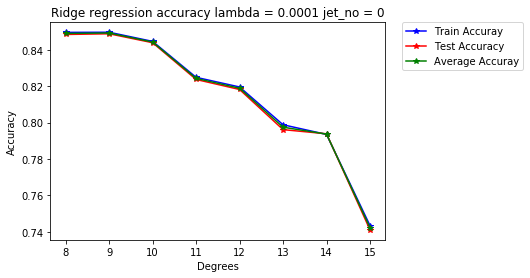

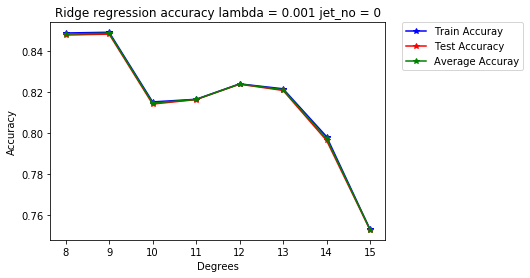

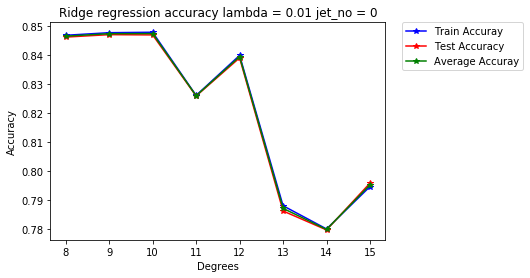

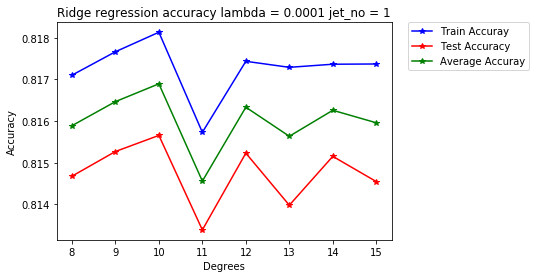

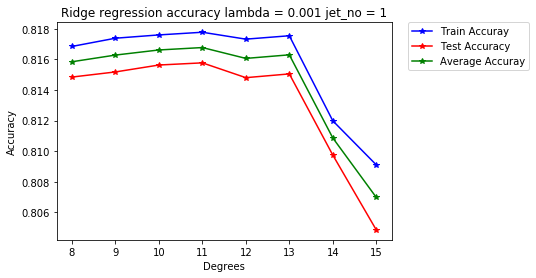

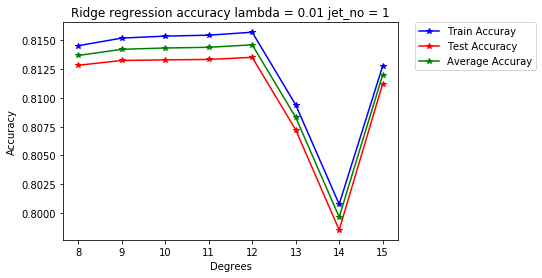

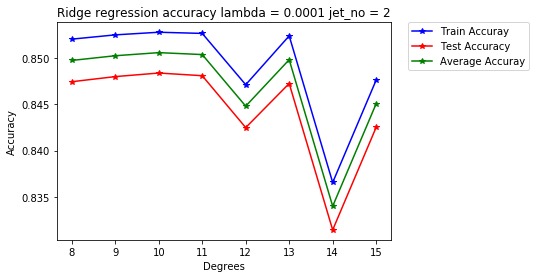

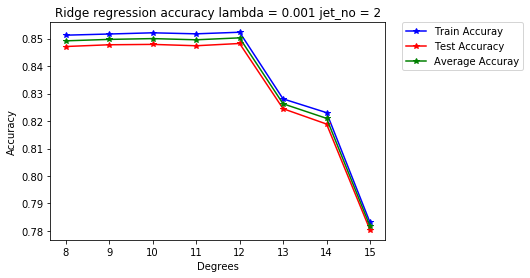

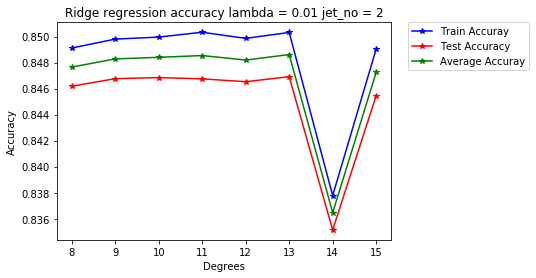

In [10]:
degrees = [x for x in range(8, degree + 1)]
for jet_no in range(len(dict_jets_train)):
    for lambda_ in lambdas:
        train_acc = [x["acc"][0] for x in results if (x["idx"] == jet_no and x["param"][0] == lambda_)]
        test_acc = [x["acc"][1] for x in results if (x["idx"] == jet_no and x["param"][0] == lambda_)]
        total_acc = [x["acc"][2] for x in results if (x["idx"] == jet_no and x["param"][0] == lambda_)] 
        plot_accurecy_chart(degrees, train_acc, test_acc, total_acc, lambda_, jet_no)